Copyright (c) 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

---

# <font color="red">Train and Deploy Models from Massive Datasets</font>
## <font color="red">Credit Card Fraud Detection use-case</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---

# Overview:

Credit card fraud is a major source of losses for any merchant, and the prevalence of this form of payment combined with the increase in online transactions makes it an important issue to try to tackle.

However fraud is still a small fraction of all transactions and training a machine learning model for this purpose tends to require a vast amount of data.

In this notebook, you will learn how to work with Spark within the [Data Science](https://docs.oracle.com/en-us/iaas/data-science/using/data-science.htm) service. [Spark](https://spark.apache.org/docs/latest/) is a distributed computing framework which is available as a service on Oracle Cloud Infrastructure (OCI) as [Data Flow](https://docs.oracle.com/en-us/iaas/data-flow/using/dfs_getting_started.htm); a fully managed Spark deployment.

You will explore a synthetic dataset of credit card transactions, try models and evaluate their performance on this dataset. You will create Spark applications to run training and batch scoring on Oracle Cloud Infrastructure Data Flow, the Oracle serverless Spark platform, and then deploy a model inference server callable via a REST endpoint.



<a id="feature1"></a>
## Prerequisites

- Experience with the specific Topic: Intermediate.

- Professional experience: None

- To run this notebook, your tenancy needs to be set up to use Data Flow. See [https://docs.oracle.com/en-us/iaas/data-flow/using/dfs_getting_started.htm](https://docs.oracle.com/en-us/iaas/data-flow/using/dfs_getting_started.htm) to get started.

- To run this notebook, use the PySpark CPU v4 conda environment. To install use:

    ```
    odsc conda install -s pyspark32_p38_cpu_v2
    ```


- The notebook requires an Object Storage bucket to store the code that will be created and used by Data Flow applications, and an Object Storage bucket for the data.

- The data generation part of this use-case can be very time-consuming, depending on the amount of data you wish to generate. We recommend the use of the shape with at least 8 OCPUs. Generating terabytes of data can take several hours. To run this notebook, a medium-size dataset that can be generated in a few minutes is sufficient, but to obtain the best-performing model, training on the largest dataset is needed.


---

## Contents:

- <a href='#use_case'>Introduction</a>
- <a href="#setup">1. Setup</a>
    - <a href="#variables">1.1. Variables</a>
    - <a href="#utilities">1.2. Utility Functions</a>
- <a href="#dataset">2. Generate the Dataset</a>
- <a href="#store_data">3. Store Dataset on Object Storage</a>
- <a href="#explore">4. Explore the Dataset</a>
    - <a href="#customer_info">4.1. Customer Information</a>
        - <a href="#age">4.1.1. Customer Age</a>
        - <a href="#gender">4.1.2. Customer Gender</a>
        - <a href="#city_population">4.1.3. Customer City Population</a>
    - <a href="#transaction_info">4.2. Transaction Information</a>
        - <a href="#day_of_week">4.2.1. Day of Week</a>
        - <a href="#weekend">4.2.2. Weekend or Weekday</a>
        - <a href="#month_of_year">4.2.3. Month of the Year</a>
        - <a href="#time_of_day">4.2.4. Time of Day</a>
        - <a href="#amount">4.2.5. Transaction Amount</a>
        - <a href="#category">4.2.6. Merchant Category</a>
        - <a href="#distance">4.2.7. Distance to Merchant</a>
- <a href="#features">5. Feature Engineering</a>
    - <a href="#build_features">5.1. Build the feature set</a>
    - <a href="#split_set">5.2. Split Train and Test sets</a>
    - <a href="#rebalance">5.3. Balance Classes</a>
    - <a href="#eval_helper">5.4. Model Evaluation helper</a>
- <a href="#model_selection">6. Model Selection</a>
    - <a href="#lr">6.1. Logistic Regression Model</a>
    - <a href="#dt">6.2. Decision Tree Classifier Model</a>
    - <a href="#rf">6.3. Random Forest Classifier</a>
    - <a href="#gbt">6.4. Gradient Boosted Trees</a>
- <a href="#df_training">7. Running Training on OCI Data Flow</a>
    - <a href="#training_script">7.1. Data Flow Training Application script</a>
    - <a href="#test_training">7.2. Test the Data Flow Application script locally</a>
    - <a href="#training_app">7.3. Create the Data Flow Application</a>
    - <a href="#training_run">7.4. Create a Data Flow Training Run</a>
    - <a href="#edit_script">7.5. Editing Data Flow applications</a>
- <a href="#df_scoring">8. Create a Batch Scoring Application</a>
    - <a href="#scoring_script">8.1. Data Flow Batch Scoring Application script</a>
    - <a href="#scoring_run">8.2. Create a Data Flow Run for scoring</a>
- <a href="#model_cat">9. Create a Model in Model Catalog</a>
    - <a href="#artifact">9.1. Prepare the Model Artifact for Model Catalog</a>
    - <a href="#model_script">9.2. Create the Inference Model script</a>
    - <a href="#pull_model">9.3. Get the trained model into the model deployment folder</a>
    - <a href="#save_to_cat">9.4. Save the model into Model Catalog</a>
    - <a href="#test_model">9.5. Test the model locally</a>
- <a href="#md">10. Deploy the model</a>
    - <a href="#md_create">10.1 Create a Model Deployment and Endpoint</a>
    - <a href="#test_md">10.2 Test the Model Deployment Endpoint</a>
- <a href="#clean">11. Clean up</a>
    - <a href="#md_clean">11.1 Clean up model deployment</a>
    - <a href="#clean_mc">11.2 Remove the model from Model Catalog</a>
    - <a href="#clean_mc">11.3 Delete Data Flow applications</a>
    - <a href="#clean_mc">11.4 Delete Local files</a>
    - <a href="#clean_mc">11.5 Delete the datasets and dataset generator</a>
- <a href="#reference">References</a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

In [ ]:
# make sure ads is version 2.6.2 (2.6.3 to 2.6.6 had a bug)
!pip install -U oracle-ads==2.6.2 matplotlib==3.3.0 --quiet

In [1]:
import ads
import json
import matplotlib.pyplot as plt
import numpy as np
import oci
import ocifs
import os
import pandas as pd
import pyspark
import re
import requests
import sys

from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
from ads.dataflow.dataflow import DataFlow
from ads.model.generic_model import GenericModel
from ads.model.deployment import ModelDeployer

from datetime import datetime
from glob import glob

from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.functions import vector_to_array

from sklearn.metrics import auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, \
                            PrecisionRecallDisplay, roc_auc_score, roc_curve, RocCurveDisplay

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType


<a id='use_case'></a>
# Introduction

<a id='setup'></a>
## 1. Setup

<a id='variables'></a>
### 1.1 Variables

Please populate the variables in the next cell with your own values.

In [2]:
# home folder
home_folder = '~/'
# Object Storage tenancy namespace
tenancy_namespace = '<namespace>'
# Data bucket name, where the data will be stored
data_bucket_name = '<bucket_name>'
# code bucket name, where the Data Flow code will be stored
code_bucket_name = '<bucket_name>'
# logs bucket name, where Data Flow log files will be sent
logs_bucket_name = '<bucket_name>'

Configure resource principal for the local Spark context. This allow access to things like Object Storage from the local Spark instance.

In [4]:
!odsc core-site config --overwrite --authentication resource_principal

The core-site.xml is being written to /home/datascience/spark_conf_dir/core-site.xml


If the Data Science environment does not use Resource Principal, you can set up authentication using an API key with:

In [5]:
# uncomment to use the following:
# !odsc core-site config --overwrite --authentication api_key

<a id="utilities"></a>
### 1.2. Utility Functions

In this section, you will define utility functions to get a Spark session. The way to obtain the Spark session depends on whether the code runs locally, in a Data Science Notebook or in Data Flow.

In [6]:
def is_in_oci():
    return os.environ.get("HOME") == "/home/dataflow" or os.environ.get("HOME") == "/home/datascience"

def get_spark_session(
        app_name, 
        file_location=None, 
        profile_name=None, 
        spark_config={}
    ):
    """
    Get a Spark session in a way that supports running locally or in Data Flow.
    """
    
    # If we are in Data Flow or Data Science, we assume the instance uses Instance Principal 
    # for authorization, and we can create a Spark Session Builder without config
    if is_in_oci():
        spark_builder = SparkSession.builder.appName(app_name)
        
    # If we run on a local machine, we need to provide authentication from the OCI config
    else:
        # Import OCI.
        try:
            import oci
        except:
            raise Exception(
                "You need to install the OCI python library to test locally"
            )
        # Use defaults for anything unset.
        if file_location is None:
            file_location = oci.config.DEFAULT_LOCATION
        if profile_name is None:
            profile_name = oci.config.DEFAULT_PROFILE

        # Load the config file.
        try:
            oci_config = oci.config.from_file(
                file_location=file_location, profile_name=profile_name
            )
        except Exception as e:
            print("You need to set up your OCI config properly to run locally")
            raise e
        conf = SparkConf()
        conf.set("fs.oci.client.auth.tenantId", oci_config["tenancy"])
        conf.set("fs.oci.client.auth.userId", oci_config["user"])
        conf.set("fs.oci.client.auth.fingerprint", oci_config["fingerprint"])
        conf.set("fs.oci.client.auth.pemfilepath", oci_config["key_file"])
        conf.set(
            "fs.oci.client.hostname",
            "https://objectstorage.\{0\}.oraclecloud.com".format(oci_config["region"]),
        )
        spark_builder = SparkSession.builder.appName(app_name).config(conf=conf)

    # Add in extra configuration.
    for key, val in spark_config.items():
        spark_builder.config(key, val)

    # Create the Spark session.
    session = spark_builder.getOrCreate()
    return session
        

<a id="dataset"></a>
## 2. Generate the Dataset

In this section, you will generate a synthetic credit card transaction dataset, using the project at [https://github.com/namebrandon/Sparkov_Data_Generation](https://github.com/namebrandon/Sparkov_Data_Generation)


- Go to the Launcher, open a Terminal window and perform the following tasks:

- Clone the data generation repository:

    ```bash
    git clone https://github.com/namebrandon/Sparkov_Data_Generation
    ```


- Get into the `Sparkov_Data_Generation` folder and install the requirements:

    ```bash
    cd Sparkov_Data_Generation
    pip install -r requirements.txt
    ```


- Generate a small training dataset with 100 customers and transactions over 2 years:

    ```bash
    python datagen.py -n 100 -o "data/training set/small" 01-01-2012 12-31-2013
    ```


- Generate a medium training dataset with 1000 customers and transactions over 2 years:

    ```bash
    python datagen.py -n 1000 -o "data/training set/medium" 01-01-2012 12-31-2013
    ```


- Generate a medium scoring dataset with 1000 customers and transactions over 2 years:

    ```bash
    python datagen.py -n 1000 -o "data/scoring set/medium" 01-01-2012 12-31-2013
    ```


- To generate a very large training dataset of ~1.5TB and ~5.5B records, to use as a realistic out-of-memory training set with the Data Flow application, use the settings below.

    Note: this will take a minimum of 2h on the largest shape VM available, and requires that you have selected at least 2000GB of storage when provisioning the notebook session. You can skip this step and run the notebook with the medium dataset but will get the best-performing model only when training with the very large dataset.

    ```bash
    python datagen.py -n 250000 -o "data/training set/xlarge" 01-01-2000 12-31-2020
    ```

The data generated is located in the data folder of the Sparkov_Data_Generation project.

The file pattern insures all csv files named after the profiles are picked up, excluding the 'customers.csv'. Data files include *male*.csv and *female*.csv so *male*.csv covers both. In this notebook, the medium dataset is used for exploration.


In [7]:
data_folder = os.path.join(os.path.expanduser(home_folder), 'Sparkov_Data_Generation/data/')
file_pattern = 'training set/medium/*male*.csv'

<a id="store_data"></a>
## 3. Store Dataset on Object Storage

The Data Flow applications cannot access the local storage on the Data Science notebook, so the data needs to be moved to Object Storage.

The helper function in the following cell moves the local files to the data Object Storage bucket defined in setup.

In [8]:
def store_on_oss(tenancy_namespace, bucket_name, data_folder, file_pattern):
    if is_in_oci():
        signer = oci.auth.signers.get_resource_principals_signer()
        object_storage_client = oci.object_storage.ObjectStorageClient(config={}, signer=signer)
    else:
        config = oci.config.from_file()
        object_storage_client = oci.object_storage.ObjectStorageClient(config)

    files = glob(data_folder + file_pattern)
    file_count = len(files)
    for i, file in enumerate(files):
        print(f'{i + 1}/{file_count} copy: {file}')
        filename = file.replace(data_folder, '')
        print(f'{i + 1}/{file_count} to: {bucket_name}@{tenancy_namespace}/{filename}')
        with open(file, 'r') as f:
            put_object_response = object_storage_client.put_object(
                namespace_name=tenancy_namespace,
                bucket_name=bucket_name,
                object_name=filename,
                put_object_body=f
            )
        # sign in every so often because the auth has a timeout
        if i == 100:
            signer = oci.auth.signers.get_resource_principals_signer()
            object_storage_client = oci.object_storage.ObjectStorageClient(config={}, signer=signer)

In [66]:
# run the function for the various datasets
file_pattern_to_store = 'training set/medium/*male*.csv'
store_on_oss(tenancy_namespace, data_bucket_name, data_folder, file_pattern_to_store)

file_pattern_to_store = 'training set/small/*male*.csv'
store_on_oss(tenancy_namespace, data_bucket_name, data_folder, file_pattern_to_store)

file_pattern_to_store = 'scoring set/medium/*male*.csv'
store_on_oss(tenancy_namespace, data_bucket_name, data_folder, file_pattern_to_store)

1/60 copy: /home/datascience/Sparkov_Data_Generation/data/training set/medium/young_adults_male_urban_200-399.csv
1/60 to: fraud-detection-data@bigdatadatasciencelarge/training set/medium/young_adults_male_urban_200-399.csv
2/60 copy: /home/datascience/Sparkov_Data_Generation/data/training set/medium/adults_50up_male_urban_600-799.csv
2/60 to: fraud-detection-data@bigdatadatasciencelarge/training set/medium/adults_50up_male_urban_600-799.csv
3/60 copy: /home/datascience/Sparkov_Data_Generation/data/training set/medium/young_adults_male_rural_200-399.csv
3/60 to: fraud-detection-data@bigdatadatasciencelarge/training set/medium/young_adults_male_rural_200-399.csv
4/60 copy: /home/datascience/Sparkov_Data_Generation/data/training set/medium/adults_2550_female_rural_600-799.csv
4/60 to: fraud-detection-data@bigdatadatasciencelarge/training set/medium/adults_2550_female_rural_600-799.csv
5/60 copy: /home/datascience/Sparkov_Data_Generation/data/training set/medium/young_adults_female_rural_

<a id="explore"></a>
## 4. Explore the Dataset

You will load the dataset and sample a subset for exploration.

In [9]:
sc = get_spark_session(app_name="CC_Fraud_Detection")

sc.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
sc.conf.set("spark.sql.debug.maxToStringFields", 1000)
df = sc.read.option("delimiter", "|").csv(data_folder + file_pattern, header=True, inferSchema=True)


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/14 17:48:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


You can have a look at the schema with:

In [10]:
df.printSchema()

root
 |-- ssn: string (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- acct_num: long (nullable = true)
 |-- profile: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- trans_date: string (nullable = true)
 |-- trans_time: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merchant: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)



and get a sense of the distribution of the data with:

In [11]:
df.count()

1725598

You can check the ratio of fraudulent vs. legitimate transactions with:

In [12]:
df.groupBy('is_fraud').count().show(2)

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   9468|
|       0|1716130|
+--------+-------+



Down-sampling the dataset will make it easier to run local exploration tasks. Here the dataset is down-sampled to 5% of the original 1.6M+ rows.

In [13]:
df_sample = df.sample(False, 0.05)

You can check that the new row count is much smaller:

In [14]:
df_sample.count()

86436

In [15]:
df_sample.groupBy('is_fraud').count().show(2)

+--------+-----+
|is_fraud|count|
+--------+-----+
|       1|  457|
|       0|85979|
+--------+-----+



<a id="customer_info"></a>
### 4.1. Customer Information

The first 16 columns correspond to the customer profile:
- ssn: string (nullable = true)
- cc_num: long (nullable = true)
- first: string (nullable = true)
- last: string (nullable = true)
- gender: string (nullable = true)
- street: string (nullable = true)
- city: string (nullable = true)
- state: string (nullable = true)
- zip: integer (nullable = true)
- lat: double (nullable = true)
- long: double (nullable = true)
- city_pop: integer (nullable = true)
- job: string (nullable = true)
- dob: string (nullable = true)
- acct_num: long (nullable = true)
- profile: string (nullable = true)

Looking at how the data is generated, we can see that any customer may have fraudulent transactions, so that `ssn`, `acct_num`, `name`, or `job` may not be relevant.

Each customer has a specific profile, which determines the type, amount, and frequency of transactions. The profiles consider `gender`, `age`, and type of city (urban or rural), so gender, age, and city details are relevant columns.

In each profile, there is also a flag determining if the customer travels or not. Note that at the time of writing (v1.0) the generator code does not take this flag into account)


<a id="age"></a>
#### 4.1.1. Customer Age

Let's have a look at the customer attributes, starting with age:

<AxesSubplot: title={'center': 'Fraud vs. Legitimate'}, ylabel='Frequency'>

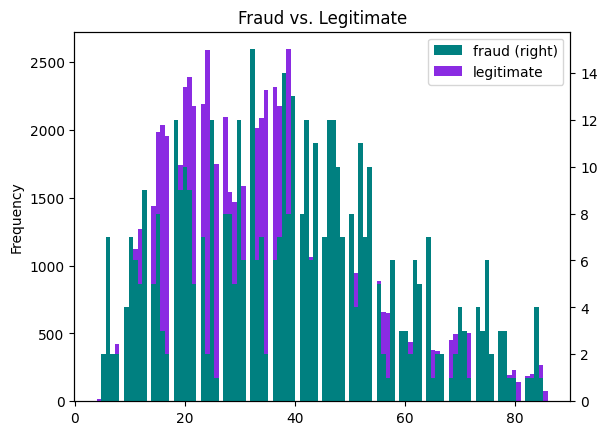

In [16]:
df_sample\
    .withColumn('age',floor(datediff(col('trans_date'), to_date(col('dob'), 'yyyy-mm-dd'))/365.25))\
    .withColumn('fraud', when(col('is_fraud') == 1, col('age')).when(col('is_fraud') == 0, None))\
    .withColumn('legitimate', when(col('is_fraud') == 0, col('age')).when(col('is_fraud') == 0, None))\
    .select(['fraud', 'legitimate'])\
    .toPandas().plot.hist(by=['fraud', 'legitimate'], histtype='bar', bins=100, title='Fraud vs. Legitimate', xlabel='Age', secondary_y='fraud')


Customer age distribution between fraudulent and non fraudulent transactions is visually different indicating age is a relevant factor.

<a id="gender"></a>
#### 4.1.2. Customer Gender


<AxesSubplot: title={'center': 'legitimate'}, ylabel='count'>

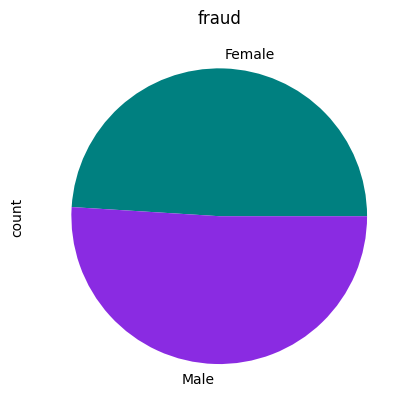

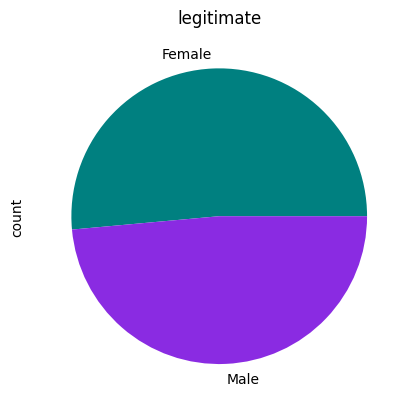

In [17]:
df_sample.filter(col('is_fraud') == 1)\
    .withColumn('gender',when((col('gender') == 'M'),'Male').when((col('gender') == 'F'),'Female'))\
    .select('gender')\
    .groupBy('gender')\
    .count()\
    .toPandas().set_index('gender').plot.pie(y='count', title='fraud', legend=None)

df_sample.filter(col('is_fraud') == 0)\
    .withColumn('gender',when((col('gender') == 'M'),'Male').when((col('gender') == 'F'),'Female'))\
    .select('gender')\
    .groupBy('gender')\
    .count()\
    .toPandas().set_index('gender').plot.pie(y='count', title='legitimate', legend=None)

The dataset is fairly balanced in terms of gender distribution.

<a id="city_population"></a>
#### 4.1.3. Customer City Population


<AxesSubplot: title={'center': 'Fraud vs. Legitimate'}, ylabel='Frequency'>

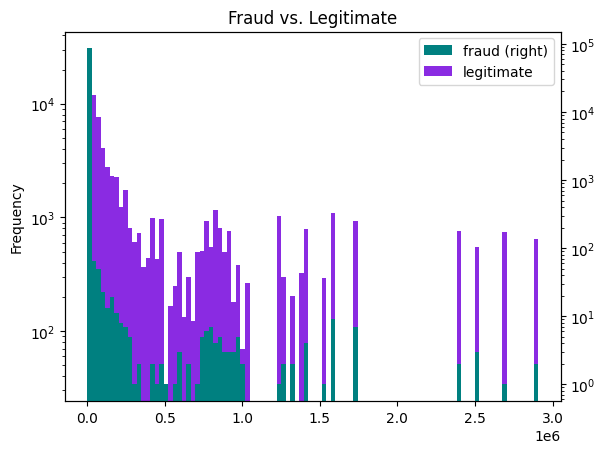

In [18]:
df_sample\
    .withColumn('fraud', when(col('is_fraud') == 1, col('city_pop')).when(col('is_fraud') == 0, 0))\
    .withColumn('legitimate', when(col('is_fraud') == 0, col('city_pop')).when(col('is_fraud') == 0, 0))\
    .select(['fraud', 'legitimate'])\
    .toPandas().plot.hist(by=['fraud', 'legitimate'], histtype='bar', bins=100, logy=True, title='Fraud vs. Legitimate', xlabel='Population', secondary_y='fraud')
                

The generator creates profiles based on urban or rural areas, yet the population distribution seems similar with both fraud and legitimate transactions.

<a id="transaction_info"></a>
### 4.2. Transaction Information

The next 10 columns cover the transaction information, including the label `is_fraud`:
- trans_num: string (nullable = true)
- trans_date: string (nullable = true)
- trans_time: string (nullable = true)
- unix_time: integer (nullable = true)
- category: string (nullable = true)
- amt: double (nullable = true)
- is_fraud: integer (nullable = true)
- merchant: string (nullable = true)
- merch_lat: double (nullable = true)
- merch_long: double (nullable = true)

Let's have a look at the transaction columns to see what may be relevant:



<a id="day_of_week"></a>
#### 4.2.1. Day of Week

First, let's look for patterns of fraudulent transactions vs. legitimate ones in the transaction date:

<AxesSubplot: title={'center': 'Legitimate'}, xlabel='Day of the Week'>

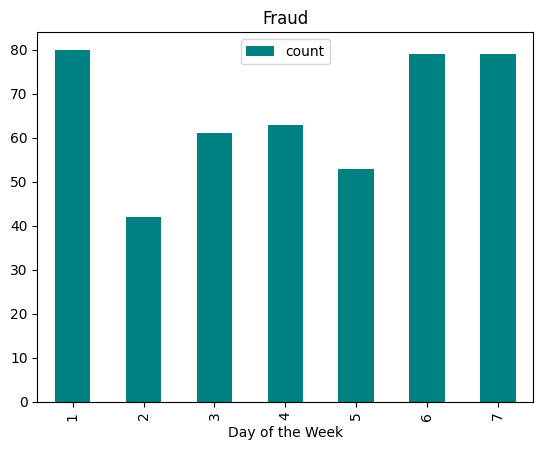

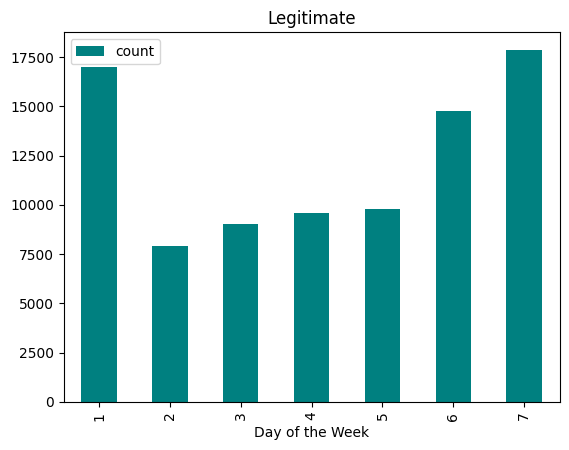

In [19]:
df_sample.filter(col('is_fraud') == 1)\
    .withColumn('day_of_week', dayofweek(col('trans_date')))\
    .select('day_of_week')\
    .groupBy('day_of_week')\
    .count()\
    .sort('day_of_week')\
    .toPandas().plot.bar(y='count', x='day_of_week', title='Fraud', xlabel='Day of the Week')

df_sample.filter(col('is_fraud') == 0)\
    .withColumn('day_of_week', dayofweek(col('trans_date')))\
    .select('day_of_week')\
    .groupBy('day_of_week')\
    .count()\
    .sort('day_of_week')\
    .toPandas().plot.bar(y='count', x='day_of_week', title='Legitimate', xlabel='Day of the Week')


Day of the week seem to have some relevance although it may just be our sample.

<a id="weekend"></a>
#### 4.2.2. Weekend or Weekday

Let's now look if fraud is more prevalent on weekend or weekdays:

<AxesSubplot: title={'center': 'Legitimate'}, ylabel='count'>

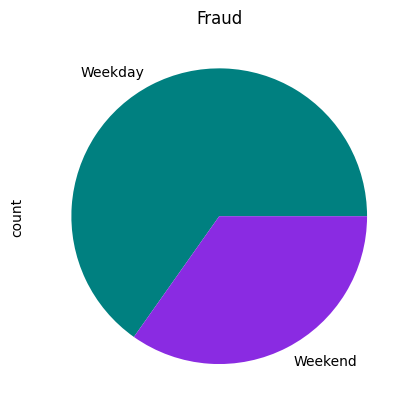

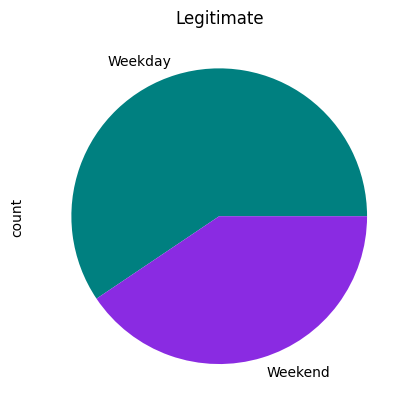

In [20]:
df_sample.filter(col('is_fraud') == 1)\
    .withColumn('is_weekend', when(dayofweek(col("trans_date")).isin([1,7]), 'Weekend').otherwise('Weekday'))\
    .select('is_weekend')\
    .groupBy('is_weekend')\
    .count()\
    .toPandas().set_index('is_weekend').plot.pie(y='count', title='Fraud', legend=None)
df_sample.filter(col('is_fraud') == 0)\
    .withColumn('is_weekend', when(dayofweek(col("trans_date")).isin([1,7]), 'Weekend').otherwise('Weekday'))\
    .select('is_weekend')\
    .groupBy('is_weekend')\
    .count()\
    .toPandas().set_index('is_weekend').plot.pie(y='count', title='Legitimate', legend=None)

There is a significant skew towards fraudulent transactions on weekends.

<a id="month_of_year"></a>
#### 1.4.2.3. Month of the Year

Let's now look at the month of the year

<AxesSubplot: title={'center': 'legitimate'}, xlabel='Month of the Year'>

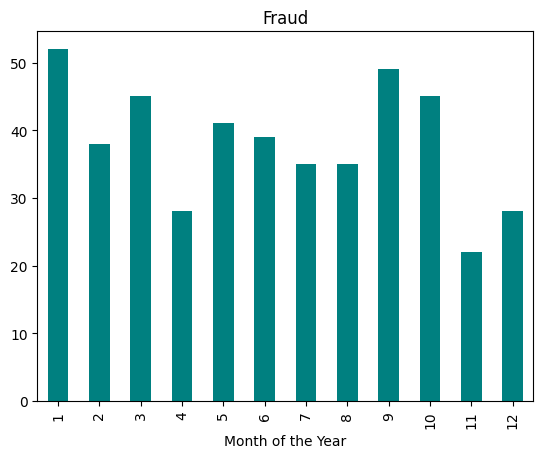

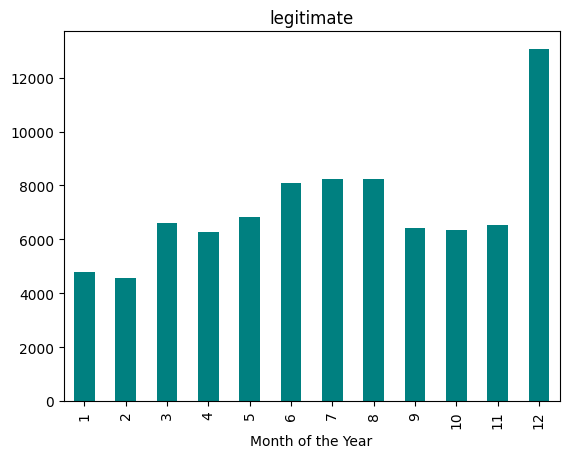

In [21]:
df_sample.filter(col('is_fraud') == 1)\
    .withColumn('month_of_year', month(col('trans_date')))\
    .select('month_of_year')\
    .groupBy('month_of_year')\
    .count()\
    .sort('month_of_year')\
    .toPandas().plot.bar(y='count', x='month_of_year', xlabel='Month of the Year', title='Fraud', legend=None)

df_sample.filter(col('is_fraud') == 0)\
    .withColumn('month_of_year', month(col('trans_date')))\
    .select('month_of_year')\
    .groupBy('month_of_year')\
    .count()\
    .sort('month_of_year')\
    .toPandas().plot.bar(y='count', x='month_of_year', xlabel='Month of the Year', title='legitimate', legend=None)


The month of the year seems relevant as fraudulent transactions are fairly evenly distributed over the whole year while legitimate transaction peek in December.

<a id="time_of_day"></a>
#### 4.2.4. Time of Day

Now let's look at the time of day:

<AxesSubplot: title={'center': 'Legitimate'}, xlabel='Hour of the Day'>

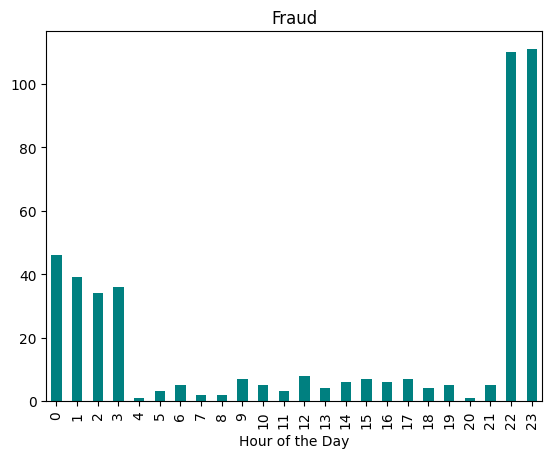

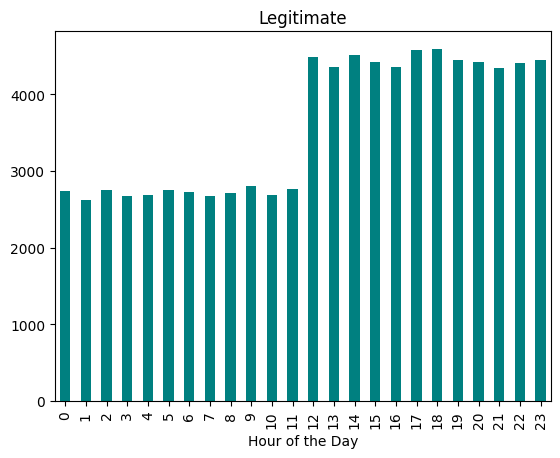

In [22]:
df_sample.filter(col('is_fraud') == 1)\
    .withColumn('hour_of_day', hour(col('trans_time')))\
    .select('hour_of_day')\
    .groupBy('hour_of_day')\
    .count()\
    .sort('hour_of_day')\
    .toPandas().plot.bar(y='count', x='hour_of_day', title='Fraud', legend=None, xlabel='Hour of the Day')

df_sample.filter(col('is_fraud') == 0)\
    .withColumn('hour_of_day', hour(col('trans_time')))\
    .select('hour_of_day')\
    .groupBy('hour_of_day')\
    .count()\
    .sort('hour_of_day')\
    .toPandas().plot.bar(y='count', x='hour_of_day', title='Legitimate', legend=None, xlabel='Hour of the Day')


Time of day is one of the factors that highlight fraudulent transactions. This is expected as the generator code specifically 
defines a higher probability of fraud during late evening and early morning hours.

<a id="amount"></a>
#### 4.2.5. Transaction Amount

Let's see what other columns may be relevant. The transaction amount distribution is expected to be a factor:

<AxesSubplot: title={'center': 'Fraud vs. Legitimate'}, ylabel='Frequency'>

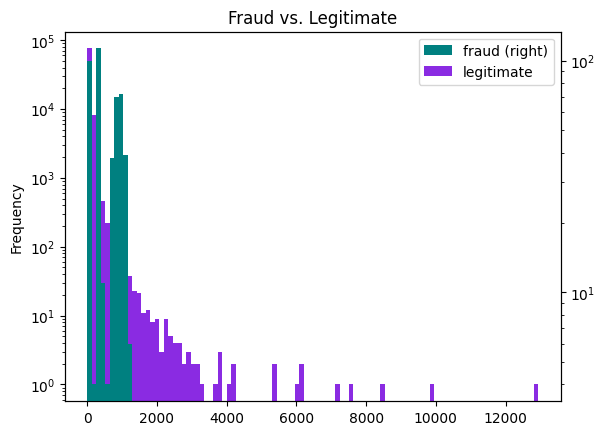

In [23]:
df_sample\
    .withColumn('fraud', when(col('is_fraud') == 1, col('amt')).when(col('is_fraud') == 0, None))\
    .withColumn('legitimate', when(col('is_fraud') == 0, col('amt')).when(col('is_fraud') == 0, None))\
    .select(['fraud', 'legitimate'])\
    .toPandas().plot.hist(by=['fraud', 'legitimate'], histtype='bar', bins=100, logy=True, title='Fraud vs. Legitimate', xlabel='Amount', secondary_y='fraud')


Amount is clearly a factor in identifying fraudulent transactions, so this column will be kept.

<a id="category"></a>
#### 4.2.6. Merchant Category

Let's look at the merchant `category` column:

<AxesSubplot: title={'center': 'legitimate'}, xlabel='category'>

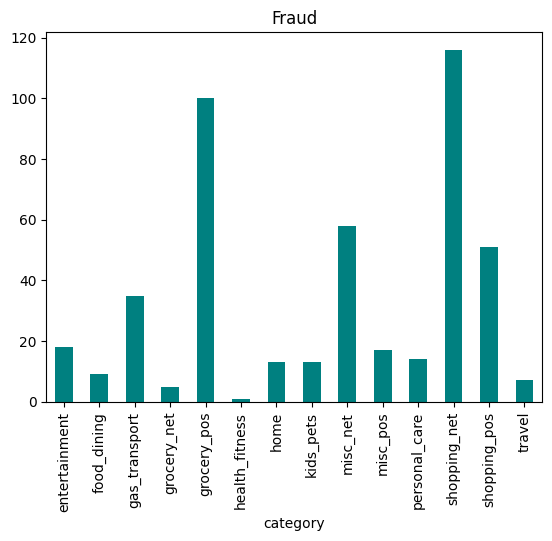

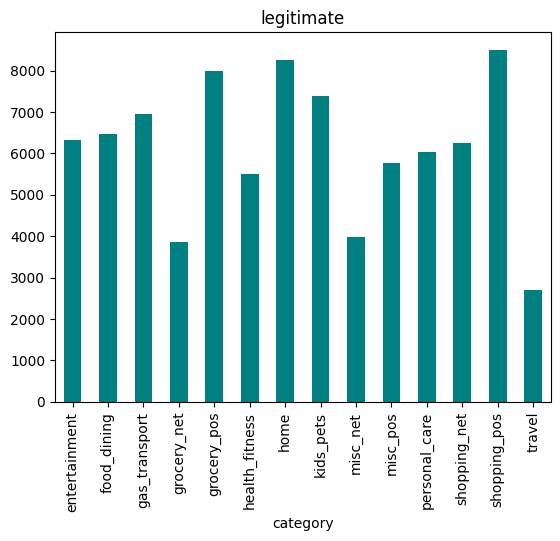

In [24]:
df_sample.filter(col('is_fraud') == 1)\
    .select('category')\
    .groupBy('category')\
    .count()\
    .orderBy('category')\
    .toPandas().plot.bar(y='count', x='category', title='Fraud', legend=None)

df_sample.filter(col('is_fraud') == 0)\
    .select('category')\
    .groupBy('category')\
    .count()\
    .orderBy('category')\
    .toPandas().plot.bar(y='count', x='category', title='legitimate', legend=None)


It also seem to carry some information about fraud. Because it is categorical data, it will need to be encoded to be suitable for regression models.

<a id="distance"></a>
#### 4.2.7. Distance to Merchant

The distance to the merchant may be relevant. The following cell is a helper function to compute distance from geo coordinates.

In [25]:
def distance(lat, long, merchant_lat, merchant_long):

    # approximate radius of earth in km
    R = 6373.0

    s_lat = np.deg2rad(float(lat))                      
    s_lng = np.deg2rad(float(long))     
    e_lat = np.deg2rad(float(merchant_lat))                       
    e_lng = np.deg2rad(float(merchant_long))  

    d = np.sin((e_lat - s_lat) / 2)**2 + np.cos(s_lat) * np.cos(e_lat) * np.sin((e_lng - s_lng) / 2)**2

    return float(2 * R * np.arcsin(np.sqrt(d)))

distance_udf = udf(lambda lat, long, merchant_lat, merchant_long: distance(lat, long, merchant_lat, merchant_long), FloatType())

Applying the function to the dataframe, using the `lat`, `long`, `merch_lat` and `merch_long`:

In [26]:
df_sample = df_sample.withColumn("distance", distance_udf(col('lat'), col('long'), col('merch_lat'), col('merch_long')))

The comparison between legitimate and fraudulent transactions can now be plotted as a histogram:

<AxesSubplot: title={'center': 'Fraud vs. Legitimate'}, ylabel='Frequency'>

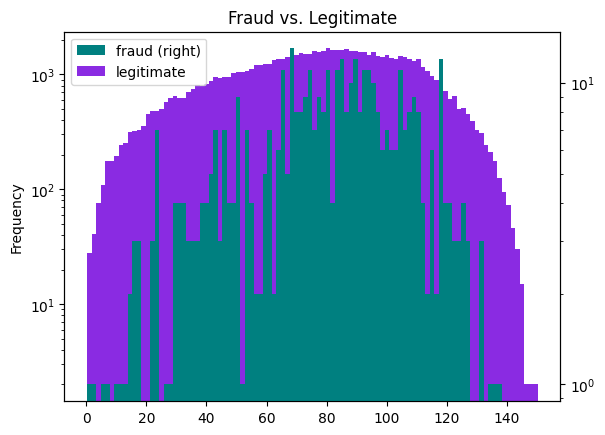

In [27]:
df_sample\
    .withColumn('fraud', when(col('is_fraud') == 1, col('distance')).when(col('is_fraud') == 0, None))\
    .withColumn('legitimate', when(col('is_fraud') == 0, col('distance')).when(col('is_fraud') == 0, None))\
    .select(['fraud', 'legitimate'])\
    .toPandas().plot.hist(by=['fraud', 'legitimate'], histtype='bar', bins=100, logy=True, title='Fraud vs. Legitimate', xlabel='Distance', secondary_y='fraud')


Distance doesn't show to be an important factor. In fact, the travelling flag is disabled in the generator code. This feature can be kept for when the flag is enabled.

<a id="features"></a>
## 5. Feature Engineering

Since many machine learning models expect numeric values as input, and many of the dataset columns are string columns, these need to be encoded to test various models.

For the customer information:

- The value for `gender` is `male` or `female` so it can be dummy encoded.
- The `street`, `city`, and `state` are difficult to 1-hot encode as this type of encoding assumes a fixed set of categories. `zip` actually encodes these values fairly accurately so it could be used alone, however despite being an integer, it is technically categorical data and not numeric.
- The `long` and `lat` pair of values is a better representation of the city location and potential area for fraud. Distance to the merchant is a metric of interest in this model, so `lat` and `long` are the better columns to use.
- The `dob` (date of birth) column is useful information but customer profiles use `age`, `age` will be computed from `dob`.
- The `city_pop` column defines whether a city is urban or rural, which is part of the profiles.

For the transaction information:

- The `amount` column is important.
- The merchant `merch_long` and `merch_lat` columns are needed for distance calculation.
- The merchant `category` is a categorical column that needs encoding.
- The transaction date and time need to be augmented to extract additional useful features.

In conclusion, you will:

- Keep and encode the `gender` column.
- Compute `age` from `dob`.
- Compute time of day, day of the week, if the day is a weekend, and the month of the year from the transaction date.
- Use `long` and `lat` to compute distance to the merchant.
- Use `city_pop` to represent city area.


With the identified features, you will put it together into a single function for feature engineering that includes the necessary transforms.

This includes the 1-hot encoding for the `category` column we have not worked on yet.

<a id="build_features"></a>
### 5.1 Build the feature set

In [28]:
def create_feature_columns(df):
    # Augments the dataset with features we identified
    
    # drop unneeded columns
    df = df.drop('ssn', 'cc_num', 'first', 'last', 'street', 'city', 'state', 
                 'zip', 'job', 'acct_num', 'profile', 'trans_num', 'unix_time', 
                 'merchant')

    # transaction date and time features
    df = df.withColumn('day_of_week', dayofweek(col('trans_date')))
    df = df.withColumn('month_of_year', month(col('trans_date')))
    df = df.withColumn('hour_of_day', hour(col('trans_time')))
    df = df.withColumn('is_weekend', col('day_of_week').isin([1,7]).cast('int'))
    
    # distance
    distance_udf = udf(lambda lat, long, merch_lat, merch_long: distance(lat, long, merch_lat, merch_long), FloatType())
    df = df.withColumn("distance", distance_udf(col('lat'), col('long'), col('merch_lat'), col('merch_long')))
    
    # customer age and gender
    df = df.withColumn('age', floor(datediff(col('trans_date'), to_date(col('dob'), 'yyyy-mm-dd'))/365.25))
    df = df.withColumn('gender', when((col('gender') == 'M'), 1).when((col('gender') == 'F'), 0).otherwise(-1))
    
    # drop no longer used columns
    df = df.drop('dob', 'trans_date', 'trans_time')

    return df

def create_feature_encoding_pipeline(df):
    # Create a pipeline model encoding categorica features
    # which can be re-used to evaluate the model
    
    # 1-hot encode merchant category
    stringIndexer = StringIndexer(inputCol='category', outputCol='category_index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=['category_classVec'])
    
    stages = [stringIndexer, encoder]
    
    numeric_columns = [col[0] for col in df.dtypes if col[1] in ['int', 'double'] and col[0] != 'is_fraud']
    assembler_inputs = ['category_classVec'] + numeric_columns
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
    stages += [assembler]
    
    # put together the pipeline with the indexer, encoder and vector assembler
    pipeline = Pipeline(stages=stages)
    # fit the pipeline with the dataset
    pipeline_model = pipeline.fit(df)
    return pipeline_model

def encode_features(df, pipeline_model):
    df = pipeline_model.transform(df)
    df = df.drop('category_classVec')    
    return df
    

Putting it all together: 
- Create the feature columns
- Create an encoding pipeline
- Encode the features with the encoding pipeline

In [29]:
df2 = create_feature_columns(df_sample)
pipeline_model = create_feature_encoding_pipeline(df2)
df2 = encode_features(df2, pipeline_model)

The dataset now includes the encoded features as a vector column named `features`.

In [30]:
df2.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- distance: float (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month_of_year: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- age: long (nullable = true)
 |-- category_index: double (nullable = false)
 |-- features: vector (nullable = true)



<a id="split_set"></a>
### 5.1. Split Train and Test sets

You will now split the dataset into train and test subsets with a ratio of 80:20, so 80% is used for training and 20% is kept aside for testing. The testing set must be data the model has never seen before.

In [31]:
train, test = df2.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 69073


Test Dataset Count: 17363


<a id="rebalance"></a>
### 5.2. Balance Classes

Fraud amounts to about 1% of transactions, so the dataset is strongly unbalanced. To give the fraud cases more weight during model training, the legitimate transactions are down-sampled to 5% of the original set. This is done on both the training set and testing set so the testing set matches the training set shape.

The scoring set will later be used to test the model on the more realistic unbalanced dataset to evaluate what can be expected for its actual performance.


In [32]:
train_downsampled = train.sampleBy('is_fraud',
                                    fractions = {
                                         1: 1,
                                         0: 0.05
                                     }, seed= 1234)
train_downsampled.groupBy('is_fraud').count().orderBy('is_fraud').show(2)

+--------+-----+
|is_fraud|count|
+--------+-----+
|       0| 3455|
|       1|  356|
+--------+-----+



In [33]:
test_downsampled = test.sampleBy('is_fraud',
                                    fractions = {
                                         1: 1,
                                         0: 0.05
                                     }, seed= 1234)
test_downsampled.groupBy('is_fraud').count().orderBy('is_fraud').show(2)

+--------+-----+
|is_fraud|count|
+--------+-----+
|       0|  882|
|       1|  101|
+--------+-----+



<a id="eval_helper"></a>
### 5.3. Model Evaluation helper

To evaluate the performance of our model, the receiver operating characteristic (ROC) curve, the Precision / Recall curve, and the confusion matrix, are useful metrics that give indications about rates of false positives and false negatives.

The next cell is a helper function to compute these functions, which can be used to evaluate the different models you will try.

- The model decision function provides a way to introspect the ability of the classifier at different thresholds or steps of the fitting process.
- The Receiver Operating Characteristic (ROC) Area Under the Curve (AUC) provides a single metric measuring the area under the ROC curve. The ROC curve looks at False Positive Rate vs. True Positive Rate across the decision function. 
- The Confusion Matrix shows the number of True Positive, True Negative, False Positive, and False Negative, that is, the number of predictions that were correctly assigned to True or False as well as incorrectly classified. 
- The Precision / Recall curve provides another way to look at model performance. Precision is the ratio of correctly predicted fraudulent transactions over the number of predicted fraudulent transactions. Recall is the ratio of correctly predicted fraudulent transactions over the number of fraudulent transactions in the dataset. Ideally, both are close to 1.0.
    
The ROC and PR curves are useful because the curves of different models can be compared directly.

ROC curves should be used when classes are balanced, while Precision-Recall curves are most useful for imbalanced datasets because ROC curve makes use of True Negatives in the False Positive Rate while it is avoided in the Precision-Recall curve.


In [34]:
def eval_model(model, data, balanced=True):
    
    preds = model.transform(data)
    y_preds = preds.select('prediction').rdd.keys().collect()
    y_score = preds.select(vector_to_array("probability")[1]).rdd.keys().collect()
    y = preds.select("is_fraud").rdd.keys().collect()
    if balanced:
        fpr, tpr, _ = roc_curve(y, y_score)
        print(f"ROC area under curve Score: {roc_auc_score(y, y_score)}")
    prec, recall, _ = precision_recall_curve(y, y_score)    
    cm = confusion_matrix(y, y_preds)
    pr = np.array([prec, recall]).T
    pr = pr[pr[:,0].argsort()]
    print(f"PR area under curve Score: {auc(pr[:,0], pr[:,1])}")
    print(f"Confusion Matrix:")
    print(cm)
    if balanced:
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm).plot()


To evaluate 'real-life' performance, the scoring dataset is used. Classes in that dataset are not balanced.

Make sure to consider this fact when looking at the numbers, especially when looking at the confusion matrix.

In [35]:
scoring_file_pattern = 'scoring set/medium/*male*.csv'
scoring_df = sc.read.option("delimiter", "|").csv(data_folder + scoring_file_pattern, header=True, inferSchema=True)


Extra features are created and all features are then encoded for that dataset, using the encoding pipeline created earlier.

In [36]:
scoring_df = create_feature_columns(scoring_df)
scoring_df = encode_features(scoring_df, pipeline_model)

<a id="model_selection"></a>
## 1.6. Model Selection

Here you will train a selection of models on the sample dataset to find the best performing solution.

Unfortunately, with Spark models, it is not possible to use the automl features of the oracle ads module, so models are trained and evaluated individually.


<a id="lr"></a>
### 1.6.1. Logistic Regression Model


In [37]:
c_lr = LogisticRegression(featuresCol='features', labelCol='is_fraud')
model_lr = c_lr.fit(train_downsampled)

Evaluate the trained Logistic Regression model on the test set:

ROC area under curve Score: 0.8988235558249702
PR area under curve Score: 0.6450464883436515
Confusion Matrix:
[[873   9]
 [ 47  54]]


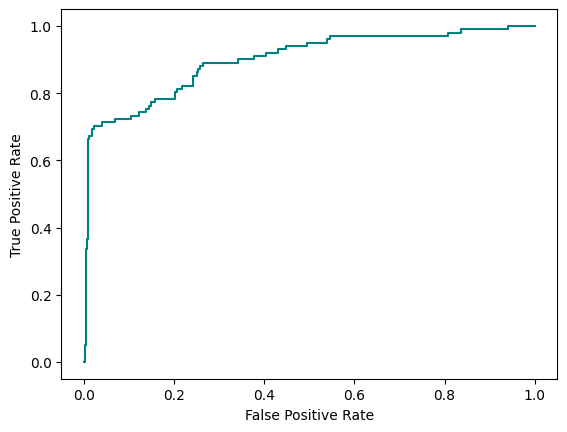

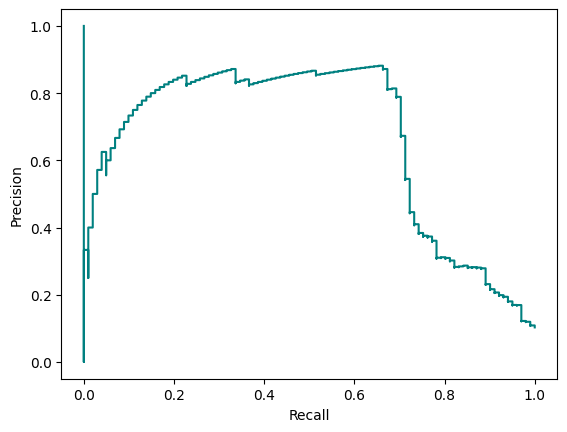

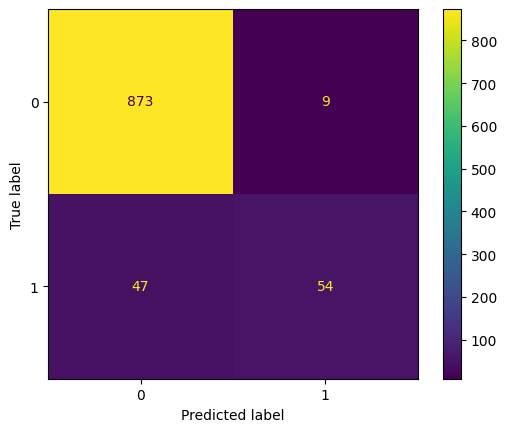

In [38]:
eval_model(model_lr, test_downsampled, balanced=True)

Evaluate the model on the scoring set:

PR area under curve Score: 0.33772017004477173
Confusion Matrix:
[[1698323   12785]
 [   4798    4641]]


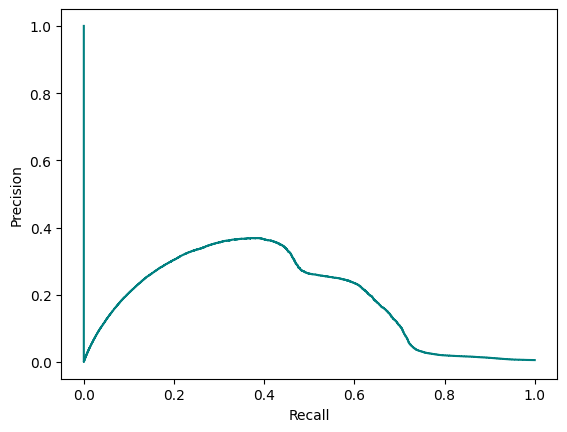

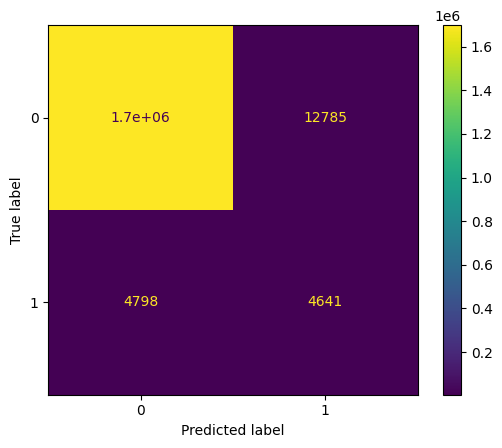

In [39]:
eval_model(model_lr, scoring_df, balanced=False)

The model performs OK on the balanced training set, but its performance drops quite significantly when looking at the unbalanced scoring set.

<a id="dt"></a>
### 1.6.2. Decision Tree Classifier Model


In [40]:
c_dt = DecisionTreeClassifier(featuresCol='features', labelCol='is_fraud')
model_dt = c_dt.fit(train_downsampled)

ROC area under curve Score: 0.9662670348667519
PR area under curve Score: 0.8095197553922506
Confusion Matrix:
[[867  15]
 [ 22  79]]


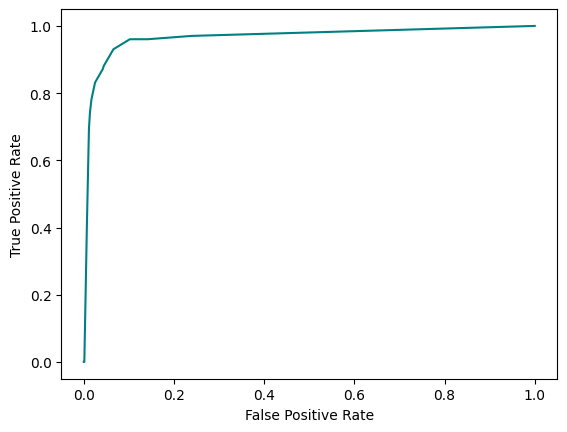

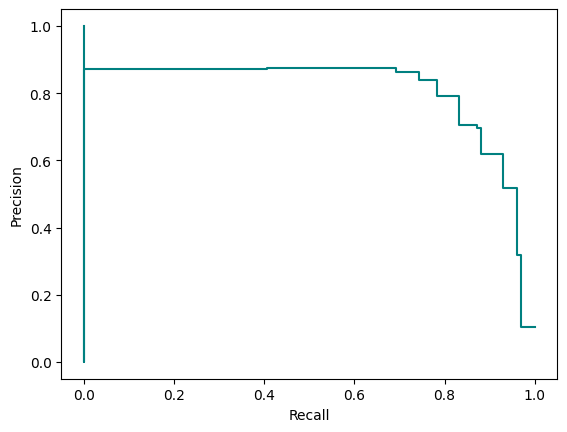

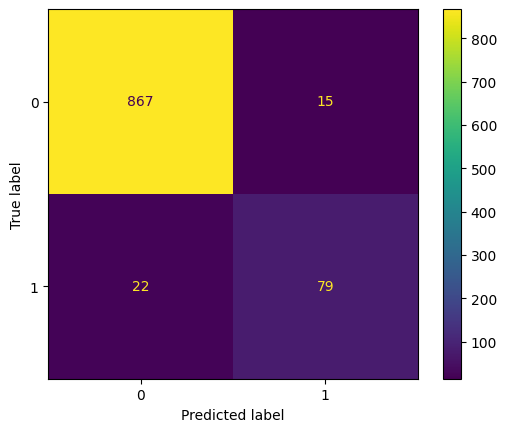

In [41]:
eval_model(model_dt, test_downsampled)

PR area under curve Score: 0.3888882263327813
Confusion Matrix:
[[1683239   27869]
 [   2390    7049]]


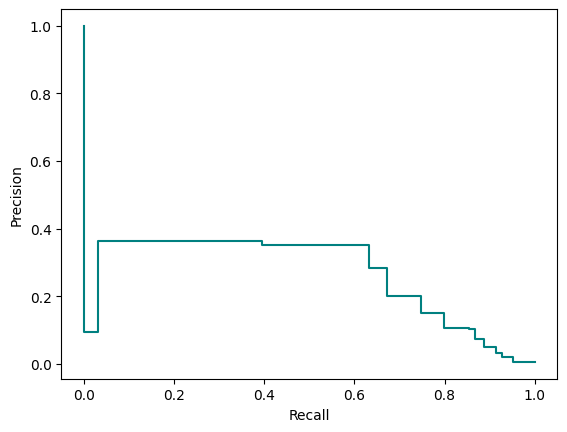

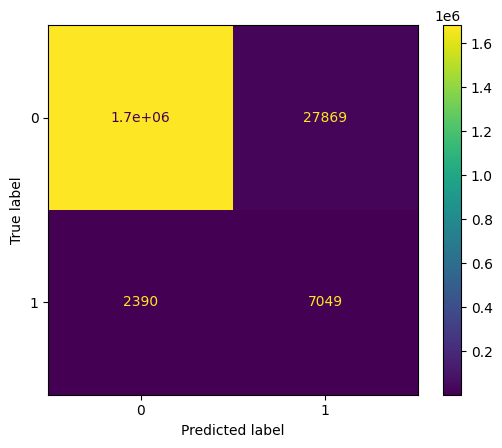

In [42]:
eval_model(model_dt, scoring_df, balanced=False)

This model performs better on the scoring set, although it performed worse on the test set.

<a id="rf"></a>
### 1.6.3. Random Forest Classifier


In [43]:
c_rf = RandomForestClassifier(featuresCol='features', labelCol='is_fraud')
model_rf = c_rf.fit(train_downsampled)

ROC area under curve Score: 0.9743157989268315
PR area under curve Score: 0.7413955975365218
Confusion Matrix:
[[869  13]
 [ 24  77]]


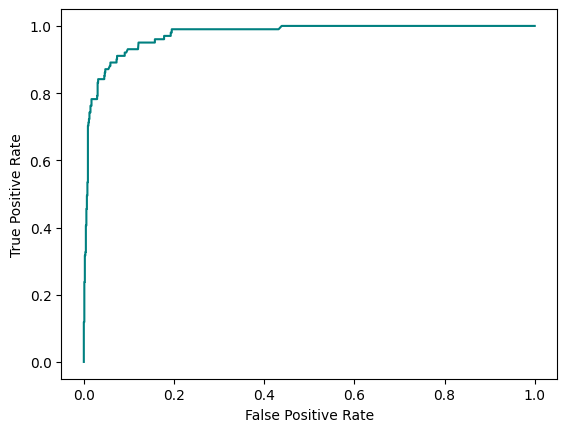

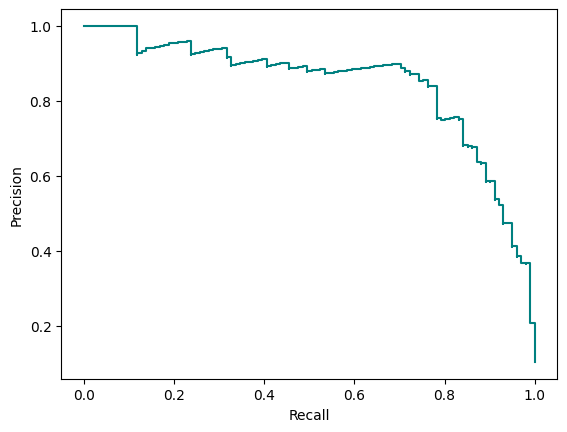

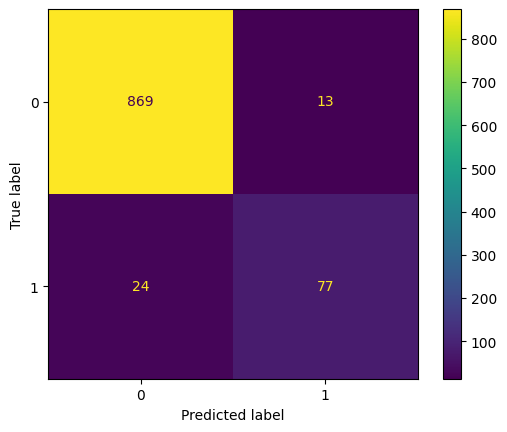

In [44]:
eval_model(model_rf, test_downsampled)

PR area under curve Score: 0.521734402571641
Confusion Matrix:
[[1693058   18050]
 [   2827    6612]]


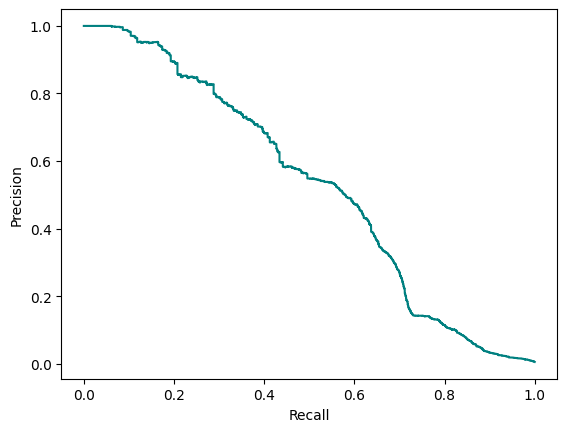

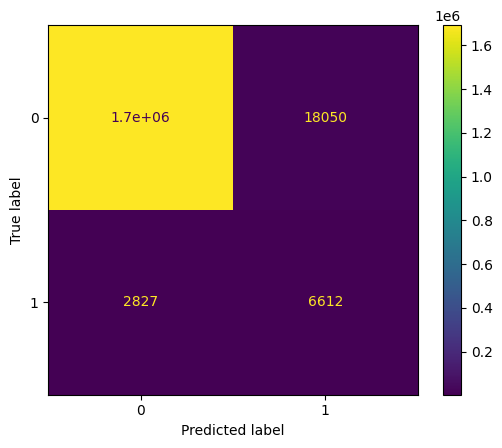

In [45]:
eval_model(model_rf, scoring_df, balanced=False)

The Random Forest model performs significantly better on both the test and scoring sets.

<a id="gbt"></a>
### 1.6.4. Gradient Boosted Trees

In [46]:
# set log level to ERROR to suppress local Spark heap memory warnings.
sc.sparkContext.setLogLevel("ERROR")
c_gbt = GBTClassifier(featuresCol='features', labelCol='is_fraud')
model_gbt = c_gbt.fit(train_downsampled)

ROC area under curve Score: 0.9806638827148021
PR area under curve Score: 0.7766585933728667
Confusion Matrix:
[[871  11]
 [ 20  81]]


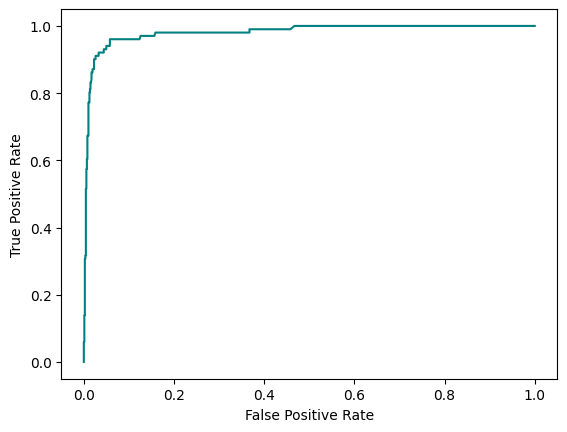

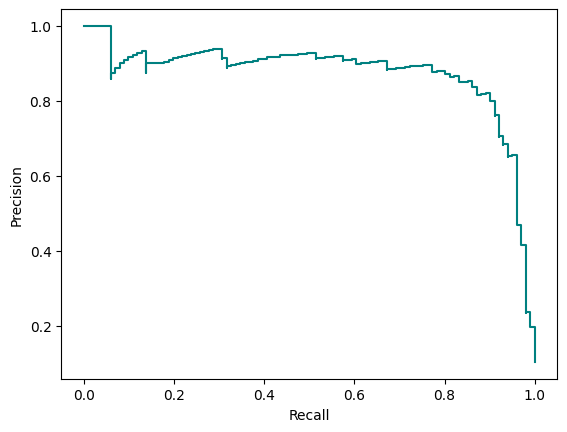

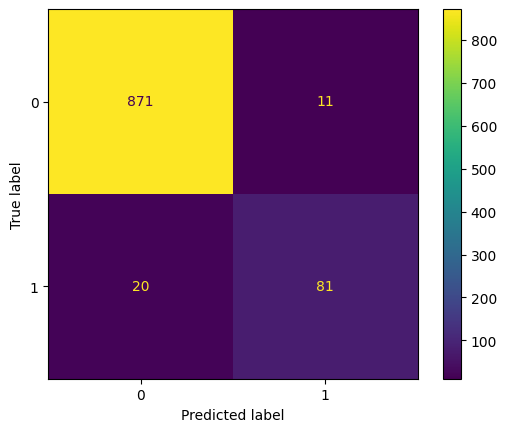

In [47]:
eval_model(model_gbt, test_downsampled)

PR area under curve Score: 0.41655670851353666
Confusion Matrix:
[[1692498   18610]
 [   2341    7098]]


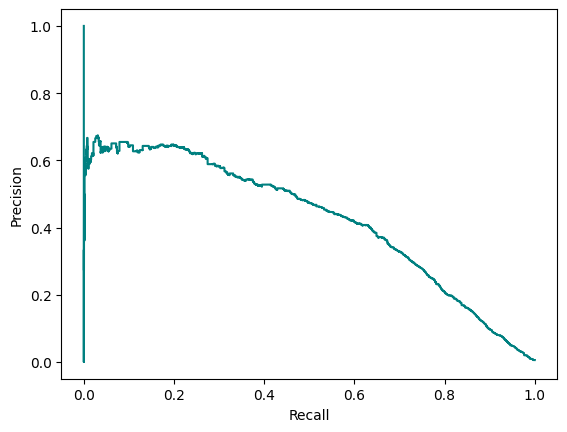

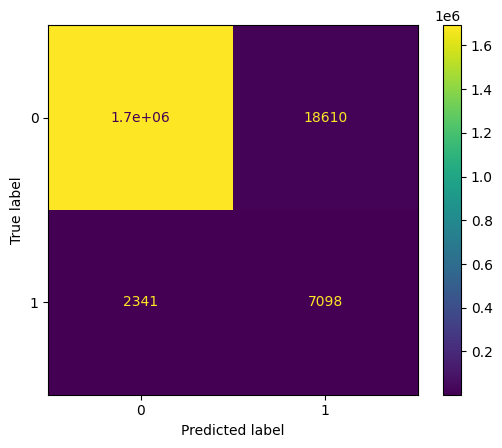

In [48]:
eval_model(model_gbt, scoring_df, balanced=False)

The Gradient Boosted Tree classsifier performs better on the test set and slightly worse on the unbalanced scoring set. Note that the rate of false negative is also the lowest, so this model seems promising to train further on a larger dataset.

The Random Forest classifier is another good option here. Swapping out the model type is trivial in the code that follows, so it is left as an exercise to the reader.

<a id="df_training"></a>
## 7. Running Training on OCI Data Flow

To run the training on the OCI Data Flow service, the application code is put together into a single script.

All the helper functions developed previously will be aggregated into a single cell, with the `main` function taking input parameters. This cell will be saved as a file to create the Data Flow application using the `%%writefile` Jupyter magic.

The DataFlow ads module uses a base folder to store the files needed to send to the Data Flow service. To test the code locally, the code module should be importable from the notebook, so it must be available from the local folder, to make this possible, the base folder is defined relative to the current path.

In [49]:
dataflow_basefolder = os.path.join(os.getcwd(), 'dataflow')
if not os.path.exists(dataflow_basefolder):
    os.makedirs(dataflow_basefolder)

<a id="training_script"></a>
### 7.1. Data Flow Training Application script

In the code, the data transformation and model training are folded into a single pipeline.

In [50]:
%%writefile {dataflow_basefolder}/fraud_detection_model_training.py
import numpy as np
import os
import sys

# Importing pyspark libraries
from pyspark.conf import SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import FloatType


def get_spark_session(app_name, file_location=None, profile_name=None, spark_config={}):

    spark_builder = SparkSession.builder.appName(app_name)

    # Add in extra configuration.
    for key, val in spark_config.items():
        spark_builder.config(key, val)

    # Create the Spark session.
    session = spark_builder.getOrCreate()
    return session


def distance(lat, long, merchant_lat, merchant_long):
    
    # approximate radius of earth in km
    R = 6373.0

    s_lat = np.deg2rad(float(lat))                      
    s_lng = np.deg2rad(float(long))     
    e_lat = np.deg2rad(float(merchant_lat))                       
    e_lng = np.deg2rad(float(merchant_long))  

    d = np.sin((e_lat - s_lat) / 2)**2 + np.cos(s_lat) * np.cos(e_lat) * np.sin((e_lng - s_lng) / 2)**2

    return float(2 * R * np.arcsin(np.sqrt(d)))


def create_feature_columns(df):
    # Augments the dataset with features we identified
    
    # drop unneeded columns
    df = df.drop('ssn', 'cc_num', 'first', 'last', 'street', 'city', 'state', 
                 'zip', 'job', 'acct_num', 'profile', 'trans_num', 'unix_time', 
                 'merchant')

    # transaction date and time features
    df = df.withColumn('day_of_week', dayofweek(col('trans_date')))
    df = df.withColumn('month_of_year', month(col('trans_date')))
    df = df.withColumn('hour_of_day', hour(col('trans_time')))
    df = df.withColumn('is_weekend', col('day_of_week').isin([1,7]).cast('int'))
    
    # distance
    distance_udf = udf(lambda lat, long, merch_lat, merch_long: distance(lat, long, merch_lat, merch_long), FloatType())
    df = df.withColumn("distance", distance_udf(col('lat'), col('long'), col('merch_lat'), col('merch_long')))

    # customer age and gender
    df = df.withColumn('age', floor(datediff(col('trans_date'), to_date(col('dob'), 'yyyy-mm-dd'))/365.25))
    df = df.withColumn('gender', when((col('gender') == 'M'), 1).when((col('gender') == 'F'), 0).otherwise(-1))
    
    # drop no longer used columns
    df = df.drop('dob', 'trans_date', 'trans_time')

    return df


def create_and_fit_model(df):
    # Create a pipeline model encoding categorica features
    # which can be re-used to evaluate the model
    
    # 1-hot encode merchant category
    stringIndexer = StringIndexer(inputCol='category', outputCol='category_index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=['category_classVec'])
    
    # assemble the feature vector with all numerical columns and the category 1-hot encoded column
    numeric_columns = [col[0] for col in df.dtypes if col[1] in ['int', 'double'] and col[0] != 'is_fraud']
    assembler_inputs = ['category_classVec'] + numeric_columns
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

    # define the model
    c_gbt = GBTClassifier(featuresCol='features', labelCol='is_fraud', maxDepth=15, maxIter=20, stepSize=0.05)
    
    # line up the stages for the whole process
    stages = [stringIndexer, encoder, assembler, c_gbt]
    
    # put together the pipeline and fit it
    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(df)
    return pipeline_model


def main(input_data_path, model_output_path, debug, spark_config={}):
    
    sc = get_spark_session(app_name='Fraud Detection Model Training', spark_config=spark_config)
    sc.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
    df = sc.read.option("delimiter", "|").csv(input_data_path, header=True, inferSchema=True)

    df = create_feature_columns(df)

    # split into train and test sets
    train, test = df.randomSplit([0.8, 0.2], seed = 2018)
    
    # downsample the majority class
    train_downsampled = train.sampleBy('is_fraud', fractions = {1: 1, 0: 0.05}, seed= 1234)

    # fit and train the model
    model = create_and_fit_model(train_downsampled)
    
    # write the fitted model to file to use for inference
    model.write().overwrite().save(model_output_path)
    
    if debug == True:
        predictions = model.transform(test)
        predictions.select('age', 'is_fraud', 'rawPrediction', 'prediction', 'probability').show(50)
        evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
        print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

            

if __name__ == "__main__":
    input_data_path = sys.argv[1]
    model_output_path = sys.argv[2]
    debug = False
    if sys.argv[3].lower() == 'true':
        debug = True

    main(input_data_path, model_output_path, debug)



Writing /home/datascience/dataflow/fraud_detection_model_training.py


<a id="test_training"></a>
### 7.2. Test the Data Flow Application script locally

We can test the application locally by importing our file and running the main function, with proper input values.

The next cell insures uses Jupyter magic syntax to insure the module created earlier is reloaded, so the code can be edited and tested again.

In [51]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In the next cell, the local module created above is loaded. In order for this to work, the folder used to save the file needs to be within the folder where this notebook runs.

In [52]:
from dataflow.fraud_detection_model_training import main

An output path for the model files is defined in the next cell

In [53]:
model_output_path = 'output/model/small'

You can now call the `main` function with the required inputs. Specific `spark_config` parameters are also passed to avoid memory issues when running on the local Spark cluster in this notebook.

In [54]:
main(os.path.join(data_folder, file_pattern), model_output_path, debug=True, 
        spark_config={
        'spark.driver.memory': '64g', 
        'spark.executor.memory': '64g'
})


+---+--------+--------------------+----------+--------------------+
|age|is_fraud|       rawPrediction|prediction|         probability|
+---+--------+--------------------+----------+--------------------+
| 37|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 37|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 37|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 37|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 37|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 37|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 37|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 37|       0|[1.33532770031104...|       0.0|[0.93527271913384...|
| 37|       0|[1.32944492985417...|       0.0|[0.93455680271233...|
| 37|       0|[1.22337036451146...|       0.0|[0.92032277969172...|
| 36|       0|[1.33993948594121...|       0.0|[0.93582885585142...|
| 37|       0|[1.32739641427196...|       0.0|[0

Test Area Under ROC: 0.9713495265899252


<a id="training_app"></a>
### 7.3. Create the Data Flow Application

The Oracle ADS package provides simple wrapper functions to create Data Flow applications and associated Runs.

Resource principal is used to authenticate. If your notebook uses an API key, change the auth to `api_key`. On a local machine use your OCI config or API key for auth.

#### Dependencies

To run spark ml on dataflow, numpy is required. Numpy is no longer provided with PySpark 3.2 and needs to beprovided by the user in an archive.

##### Option 1:
- Download fraud-detection-archive.zip from oci bucket and place it in the local dataflow folder. This is automated via wget command below.

##### Option 2:
- Alternatively, manually create the archive by following the steps given here https://docs.oracle.com/en-us/iaas/data-flow/using/third-party-libraries.htm
- In the step 3 given in the above link specify numpy==1.23.5 

In [55]:
!wget https://objectstorage.us-phoenix-1.oraclecloud.com/p/sTaB0V0SHM0RUyoCT5j7ez-A5Mtm8M5dj3VMwfaR4q-b_CO5srLiqrKoOc6txxUq/n/bigdatadatasciencelarge/b/anomaly-detection/o/fraud-detection-archive.zip -P dataflow/

--2022-12-14 18:01:58--  https://objectstorage.us-phoenix-1.oraclecloud.com/p/sTaB0V0SHM0RUyoCT5j7ez-A5Mtm8M5dj3VMwfaR4q-b_CO5srLiqrKoOc6txxUq/n/bigdatadatasciencelarge/b/anomaly-detection/o/fraud-detection-archive.zip
Resolving objectstorage.us-phoenix-1.oraclecloud.com (objectstorage.us-phoenix-1.oraclecloud.com)... 134.70.12.1, 134.70.16.1, 134.70.8.1
Connecting to objectstorage.us-phoenix-1.oraclecloud.com (objectstorage.us-phoenix-1.oraclecloud.com)|134.70.12.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36354238 (35M) [application/zip]
Saving to: ‘dataflow/fraud-detection-archive.zip’

100%[======================================>] 36,354,238  61.2MB/s   in 0.6s   

2022-12-14 18:01:58 (61.2 MB/s) - ‘dataflow/fraud-detection-archive.zip’ saved [36354238/36354238]



In [56]:
ads.set_auth(auth='resource_principal')

The Data Flow base folder needs to be passed specifically, so application and run files will be saved there, and picked up from there when editing.


In [57]:
data_flow = DataFlow(dataflow_base_folder=dataflow_basefolder)

You are now providing input parameters pointing to the files on Object Storage, so the Data Flow application can reach them.

In [58]:
pyspark_file_path = f'{dataflow_basefolder}/fraud_detection_model_training.py'
# If you have generated and stored the xlarge dataset on Object Storage, you can set this parameter to xlarge
# dataset_size = 'xlarge'
dataset_size = 'medium'
input_data_path = f'oci://{data_bucket_name}@{tenancy_namespace}/training set/{dataset_size}/*male*.csv'
model_output_path = f'oci://{data_bucket_name}@{tenancy_namespace}/output/{dataset_size}/model'
archive_file_path = f'{dataflow_basefolder}/fraud-detection-archive.zip'
debug = 'true'

You can now prepare the Data Flow application with the `prepare_app` function:

- `arguments` is a list of arguments passed to the program as if it was run on command line so we pass the variables names defined in script_parameters.

- `script_parameters` contains the default values for these variables.

In [59]:
training_app_config = data_flow.prepare_app(
                        display_name="Fraud Detection Model Training",
                        script_bucket=code_bucket_name,
                        pyspark_file_path=pyspark_file_path,
                        logs_bucket=logs_bucket_name,
                        archive_path=archive_file_path,
                        archive_bucket=code_bucket_name,
                        spark_version='3.2.1',
                        arguments=[
                            "${input_data_path}", 
                            "${model_output_path}", 
                            "${debug}"
                        ],
                        script_parameters={
                         'input_data_path': input_data_path,
                         'model_output_path': model_output_path,
                         'debug': debug
                        })


You can now create the Data Flow application:

In [60]:
training_app = data_flow.create_app(training_app_config, overwrite_script=True, overwrite_archive=True)

loop1:   0%|          | 0/2 [00:00<?, ?it/s]

To look up an existing app, use the following:

In [61]:
ads.set_auth(auth='resource_principal')
data_flow = DataFlow(dataflow_base_folder=dataflow_basefolder)
pd.DataFrame(json.loads(str(data_flow.list_apps())))[['display_name', 'id']]

,display_name,id
0,Fraud Detection Model Training,ocid1.dataflowapplication.oc1.phx.anyhqljsnif7xwia6ubdk3vbvrd6mun7vfjjqohavec7jsqzjhxgpxfpnznq
1,Fraud Detection Batch Scoring,ocid1.dataflowapplication.oc1.phx.anyhqljsnif7xwiaqd4eksues45tdoncfcxbgubcplmnv46reqlxujltxmwa
2,Fraud Detection Model Training,ocid1.dataflowapplication.oc1.phx.anyhqljtnif7xwiawgunxarvzvhrg5pyyn46wamgocdaofikyrw7arqlyaga


In the next section, you will launch a Data Flow run. If you only wanted to launch a new run on an existing app, skip the app creation part above, look up the app ID, and use the code in the following cell, replacing the id in the `load_app` function to reload the app.

In [62]:
# ads.set_auth(auth='resource_principal')
# data_flow = DataFlow(dataflow_base_folder=dataflow_basefolder)
# training_app = data_flow.load_app(<app_id>)

<a id="training_run"></a>
### 7.4. Create a Data Flow Training Run

The app was created with default input parameters. At run-time, these parameters can be modified by passing them as arguments to the prepare_run function (commented out here):

In [63]:
training_run_config = training_app.prepare_run(run_display_name=f"Fraud Detection Model Training demo",
                             num_executors=12,
                             driver_shape='VM.Standard2.16',
                             executor_shape='VM.Standard2.16',
                             # optional parameters overrides
#                              input_data_path='<new_path_to_input_dataset>',
#                              model_output_path= '<new_path_to_save_the_model>',
#                              debug=True
                            )

Finally you can launch the run.

The `wait` flag defines if the code should wait for the run to complete. A run on the medium set may take several minutes, and a run on the xlarge dataset would take several hours. The function authentication tends to time out after 30 minutes, so for large runs it is typically recommended to check the status in the OCI console.

In [67]:
ads.set_auth(auth='resource_principal')
data_flow = DataFlow(dataflow_base_folder=dataflow_basefolder)
training_run = training_app.run(training_run_config, save_log_to_local=True, wait=True)


loop1:   0%|          | 0/3 [00:00<?, ?it/s]

<a id="edit_script"></a>
### 7.5. Editing Data Flow applications

You can edit the script, run the script cell to save the script locally, and come back to the cell above to create a new run. The script will be automatically synced into Object Storage before the run starts.

Please note that the `%%writefile` magic tends to take a few seconds to update the script locally, so take a short pause before re-running the cell above to insure the latest code gets synced up.

<a id="df_scoring"></a>
## 8. Create a Batch Scoring Application

<a id="scoring_script"></a>
### 8.1. Data Flow Batch Scoring Application script

In the following cell, the script for batch scoring or inference is put together in a single cell, just like for the training script. Note that this time the model pipeline is loaded, which performs all the steps (feature building, vector assembly) and then the `transform` method is called on the pipeline.

In [68]:
%%writefile {dataflow_basefolder}/fraud_detection_batch_scoring.py
import numpy as np
import os
import sys

# Importing pyspark libraries
from pyspark.conf import SparkConf
from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import FloatType

    
def get_spark_session(app_name, file_location=None, profile_name=None, spark_config={}):

    spark_builder = SparkSession.builder.appName(app_name)
        
    # Add in extra configuration.
    for key, val in spark_config.items():
        spark_builder.config(key, val)

    # Create the Spark session.
    session = spark_builder.getOrCreate()
    return session


def distance(lat, long, merchant_lat, merchant_long):
    
    # approximate radius of earth in km
    R = 6373.0

    s_lat = np.deg2rad(float(lat))                      
    s_lng = np.deg2rad(float(long))     
    e_lat = np.deg2rad(float(merchant_lat))                       
    e_lng = np.deg2rad(float(merchant_long))  

    d = np.sin((e_lat - s_lat) / 2)**2 + np.cos(s_lat) * np.cos(e_lat) * np.sin((e_lng - s_lng) / 2)**2

    return float(2 * R * np.arcsin(np.sqrt(d)))


def create_feature_columns(df):
    # Augments the dataset with features we identified
    
    # for scoring, we don't drop the original columns: 
    # we may want the original columns in the final output.
    # Columns we need will be picked up by the pipeline
    
    # transaction date and time features
    df = df.withColumn('day_of_week', dayofweek(col('trans_date')))
    df = df.withColumn('month_of_year', month(col('trans_date')))
    df = df.withColumn('hour_of_day', hour(col('trans_time')))
    df = df.withColumn('is_weekend', col('day_of_week').isin([1,7]).cast('int'))
    
    # distance
    distance_udf = udf(lambda lat, long, merch_lat, merch_long: distance(lat, long, merch_lat, merch_long), FloatType())
    df = df.withColumn("distance", distance_udf(col('lat'), col('long'), col('merch_lat'), col('merch_long')))
    
    # customer age and gender
    df = df.withColumn('age', floor(datediff(col('trans_date'), to_date(col('dob'), 'yyyy-mm-dd'))/365.25))
    df = df.withColumn('gender', when((col('gender') == 'M'), 1).when((col('gender') == 'F'), 0).otherwise(-1))
    
    return df


def main(input_data_path, model_path, predictions_output_path, debug, spark_config={}):
    
    # create the session
    sc = get_spark_session(app_name='Fraud Detection Model Training', spark_config=spark_config)
    sc.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
    
    # load the data
    df = sc.read.option("delimiter", "|").csv(input_data_path, header=True, inferSchema=True)
    original_cols = df.columns

    print("Dataset Count: " + str(df.count()))

    # augment the dat with tnew columns
    df = create_feature_columns(df)
    
    # load the model
    # edit
    model = PipelineModel.load(model_path)

    # predict
    predictions = model.transform(df)
    
    # show some results
    predictions.select('age', 'is_fraud', 'rawPrediction', 'prediction', 'probability').show(50)
    evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
    print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
    predictions.printSchema()
    predictions = predictions.select(original_cols + ['prediction'])
    predictions.write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").save(predictions_output_path)

if __name__ == "__main__":
    input_data_path = sys.argv[1]
    model_path = sys.argv[2]
    predictions_output_path = sys.argv[3]
    debug = False
    if sys.argv[4].lower() == 'true':
        debug = True

    main(input_data_path, model_path, predictions_output_path, debug)



Writing /home/datascience/dataflow/fraud_detection_batch_scoring.py


In [69]:
pyspark_file_path = f'{dataflow_basefolder}/fraud_detection_batch_scoring.py'

# Note the inference dataset should be different from the training set
inference_dataset_size = 'small'
input_data_path = f'oci://{data_bucket_name}@{tenancy_namespace}/training set/{inference_dataset_size}/*male*.csv'
archive_file_path = f'{dataflow_basefolder}/fraud-detection-archive.zip'
predictions_output_path = f'oci://{data_bucket_name}@{tenancy_namespace}/output/{inference_dataset_size}/predictions/predictions.csv'
debug = 'true'

In [70]:
ads.set_auth(auth='resource_principal')
data_flow = DataFlow(dataflow_base_folder=dataflow_basefolder)

In [71]:
scoring_app_config = data_flow.prepare_app(
                        display_name="Fraud Detection Batch Scoring",
                        script_bucket=code_bucket_name,
                        pyspark_file_path=pyspark_file_path,
                        logs_bucket=logs_bucket_name,
                        archive_path = archive_file_path,
                        spark_version='3.2.1',
                        arguments=[
                            "${input_data_path}", 
                            "${model_path}", 
                            "${predictions_output_path}",
                            "${debug}"
                        ],
                        script_parameters={
                         'input_data_path': input_data_path,
                         'model_path': model_output_path,
                         'predictions_output_path': predictions_output_path,
                         'debug': debug
                        })


In [72]:
scoring_app = data_flow.create_app(scoring_app_config, overwrite_script=True, overwrite_archive=True)

loop1:   0%|          | 0/2 [00:00<?, ?it/s]

You can also load an existing app by looking up its id, then running `load_app`

In [73]:
ads.set_auth(auth='resource_principal')
data_flow = DataFlow(dataflow_base_folder=dataflow_basefolder)
pd.DataFrame(json.loads(str(data_flow.list_apps())))[['display_name', 'id']]

,display_name,id
0,Fraud Detection Batch Scoring,ocid1.dataflowapplication.oc1.phx.anyhqljsnif7xwiaywy2mtq7wzy4qnbxukq2scqvkfqnycutuadt6obm4hxa
1,Fraud Detection Model Training,ocid1.dataflowapplication.oc1.phx.anyhqljsnif7xwia6ubdk3vbvrd6mun7vfjjqohavec7jsqzjhxgpxfpnznq
2,Fraud Detection Batch Scoring,ocid1.dataflowapplication.oc1.phx.anyhqljsnif7xwiaqd4eksues45tdoncfcxbgubcplmnv46reqlxujltxmwa
3,Fraud Detection Model Training,ocid1.dataflowapplication.oc1.phx.anyhqljtnif7xwiawgunxarvzvhrg5pyyn46wamgocdaofikyrw7arqlyaga


<a id="scoring_run"></a>
### 8.2. Create a Data Flow Run for scoring

The run is prepared the same way the training run was prepared. At run-time, you again have the opportunity to override input parameters.

In [74]:
scoring_run_config = scoring_app.prepare_run(run_display_name=f"Fraud Detection Batch Scoring - demo",
                             num_executors=2,
                             driver_shape='VM.Standard2.16',
                             executor_shape='VM.Standard2.16',
                             # optional parameter overrides
#                              input_data_path='<new_path_to_input_data>',
#                              model_path= '<path_to_model_on_object_storage>',
#                              predictions_output_path=f'<output_path_for_predictions>',
#                              debug=True
                            )

In [75]:
scoring_run = scoring_app.run(scoring_run_config, save_log_to_local=True, wait=False)

<a id="model_cat"></a> 
## 9. Create a Model in Model Catalog

<a id="artifact"></a>
### 9.1. Prepare the Model Artifact for Model Catalog

Artifacts require a local folder to store files. In the next few cells, the default `score.py` file will be overwritten by the inference script, and the Spark model files will imported into this folder.

In [76]:
path_to_artifact = f"./fraud-detection-model-deployment"
if not os.path.exists(path_to_artifact):
    os.makedirs(path_to_artifact)

In [77]:
model = GenericModel(estimator=None, 
                    auth=ads.common.auth.resource_principal(),
                    model_file_name="model",
                    serialize=False,
                    artifact_dir=path_to_artifact
                )

model.prepare(model_file_name="model",
              inference_conda_env='pyspark32_p38_cpu_v2', 
              inference_python_version='3.8',
              force_overwrite=True)

INFO:ADS:To auto-extract taxonomy metadata the model must be provided. Supported models: automl, keras, lightgbm, pytorch, sklearn, tensorflow, and xgboost.


<a id="model_script"></a>
### 9.2. Create the Inference Model script

Saving the script with the `%%writefile` magic overwrites the `score.py` file in the artifact folder

In [78]:
%%writefile {path_to_artifact}/score.py

import json
import numpy as np
import ocifs
import os
import sys

# Importing pyspark libraries
from pyspark.ml import PipelineModel
from pyspark.ml.classification import GBTClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import FloatType


model_file = 'model'

sc = SparkSession \
    .builder \
    .appName('Fraud Detection Inference') \
    .config('spark.driver.memory', '64g') \
    .config('spark.executor.memory', '64g') \
    .getOrCreate()

fs = ocifs.OCIFileSystem()

def distance(lat, long, merchant_lat, merchant_long):

    # approximate radius of earth in km
    R = 6373.0

    s_lat = np.deg2rad(float(lat))                      
    s_lng = np.deg2rad(float(long))     
    e_lat = np.deg2rad(float(merchant_lat))                       
    e_lng = np.deg2rad(float(merchant_long))  

    d = np.sin((e_lat - s_lat) / 2)**2 + np.cos(s_lat) * np.cos(e_lat) * np.sin((e_lng - s_lng) / 2)**2

    return float(2 * R * np.arcsin(np.sqrt(d)))


def create_feature_columns(df):
    # Augments the dataset with features we identified
        
    # transaction date and time features
    df = df.withColumn('day_of_week', dayofweek(col('trans_date')))
    df = df.withColumn('month_of_year', month(col('trans_date')))
    df = df.withColumn('hour_of_day', hour(col('trans_time')))
    df = df.withColumn('is_weekend', col('day_of_week').isin([1,7]).cast('int'))
    
    # distance
    distance_udf = udf(lambda lat, long, merch_lat, merch_long: distance(lat, long, merch_lat, merch_long), FloatType())
    df = df.withColumn("distance", distance_udf(col('lat'), col('long'), col('merch_lat'), col('merch_long')))
    
    # customer age and gender
    df = df.withColumn('age', floor(datediff(col('trans_date'), to_date(col('dob'), 'yyyy-mm-dd'))/365.25))
    df = df.withColumn('gender', when((col('gender') == 'M'), 1).when((col('gender') == 'F'), 0).otherwise(-1))
    
    return df


def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    
    # Load config file
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    if model_file in contents:
        model = PipelineModel.load(os.path.join(model_dir, model_file))
        return model
    else:
        raise Exception('{0} is not found in model directory {1}'.format(config_file, model_dir))
    


def predict(data, model=load_model()) -> dict:
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: { 'prediction': output from `model.predict` method }

    """

    # if the data is a single datapoint, wrap it into an array
    if not isinstance(data, list):
        data = [data]

    # load the data into a Spark dataframe
    df = sc.read.json(sc.sparkContext.parallelize(data))
    df_cols = df.columns

    print("Dataset Count: " + str(df.count()))

    # create the features and get predictions
    df = create_feature_columns(df)
    predictions = model.transform(df)
    # output original columns and the prediction column, dropping other stats that are vectors 
    # and don't serialize when using toJSON
    results = predictions.select(df_cols + ['prediction']).toJSON().map(json.loads).collect()
    
    # return the response to the request
    return {'predictions': results}


Overwriting ./fraud-detection-model-deployment/score.py


<a id="pull_model"></a>
### 9.3. Get the trained model into the model deployment folder

Next the model generated with the Spark run and saved to object storage needs to be pulled and saved into our model folder. 

To do this, load it and then save it locally:

In [79]:
sc = get_spark_session(app_name='test')
spark_model = PipelineModel.load(model_output_path)
spark_model.write().overwrite().save(f'{path_to_artifact}/model')

<a id="save_to_cat"></a>
### 9.4. Save the model into Model Catalog


In [80]:
model_id = model.save(display_name='fraud-detection-model-demo',
              description='Fraud Detection Model Deployment Demo')

['model', 'score.py', 'runtime.yaml']


loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_926e8f7c-fa7b-437b-a266-890bb1479424.zip


<a id="test_model"></a>
### 9.5. Test the model locally


Get some sample data from the small dataset to test the model:

In [81]:
delta_data = pd.read_csv(f'{data_folder}/training set/small/adults_50up_male_urban_80-99.csv', delimiter='|')
input_data = delta_data[15:20].to_json(orient='records')

results = model.verify(data=input_data)
pd.DataFrame(results['predictions']).head(10)

Dataset Count: 5


,acct_num,amt,category,cc_num,city,city_pop,dob,first,gender,is_fraud,...,profile,ssn,state,street,trans_date,trans_num,trans_time,unix_time,zip,prediction
0,4688044575,37.59,gas_transport,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2012-03-30,504e5b7897a36d5ae3fda83565ffe2bc,01:02:17,1333069337,62260,0.0
1,4688044575,77.70,shopping_pos,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2012-12-13,5e4569a5dae1c7aa11d04c7a7195321f,05:47:10,1355377630,62260,0.0
2,4688044575,59.32,entertainment,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2013-02-15,973e3642c75c14cd199a83108bd9fe09,03:17:50,1360898270,62260,0.0
3,4688044575,59.49,shopping_net,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2012-09-15,7e62101c31d0a2d5edbbab48e30e660b,01:56:54,1347674214,62260,0.0
4,4688044575,56.73,grocery_pos,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2012-06-19,e60e7f187a2e9971a80e4931f58eff63,07:56:41,1340092601,62260,0.0


<a id="md"></a>
## 10. Deploy the model

<a id="md_create"></a>
### 10.1 Create a Model Deployment and Endpoint

To create the model deployment, simply call the `deploy` method of the GenericModel

In [82]:
deployment = model.deploy(
    display_name="Fraud Detection Model Deployment - demo",
    description="Fraud Detection Model Deployment - demo",
    deployment_instance_shape="VM.Standard2.1",
    deployment_instance_count=1,
    # The following are optional
#     deployment_access_log_id="<ACCESS_LOG_OCID>",
#     deployment_log_group_id="<LOG_GROUP_ID>"
#     predict_log_group_id="<PREDICT_LOG_GROUP_OCID>",
#     deployment_predict_log_id="<PREDICT_LOG_OCID>",
    wait_for_completion=True,
    max_wait_time=600,
    poll_interval=15)

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

The deployment endpoint url is available with the following:

In [83]:
deployment.url

'https://modeldeployment.us-phoenix-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.phx.amaaaaaanif7xwiax53nr4sbv26zobofoa4samr45q6i3g6chuk46rp4zt5a'

<a id="test_md"></a>
### 10.2 Test the Model Deployment Endpoint

The deployment can be tested easily using the `predict` method of the model

In [84]:
results = model.predict(data=input_data)
pd.DataFrame(results['predictions']).head(10)

,acct_num,amt,category,cc_num,city,city_pop,dob,first,gender,is_fraud,...,profile,ssn,state,street,trans_date,trans_num,trans_time,unix_time,zip,prediction
0,4688044575,37.59,gas_transport,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2012-03-30,504e5b7897a36d5ae3fda83565ffe2bc,01:02:17,1333069337,62260,0.0
1,4688044575,77.70,shopping_pos,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2012-12-13,5e4569a5dae1c7aa11d04c7a7195321f,05:47:10,1355377630,62260,0.0
2,4688044575,59.32,entertainment,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2013-02-15,973e3642c75c14cd199a83108bd9fe09,03:17:50,1360898270,62260,0.0
3,4688044575,59.49,shopping_net,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2012-09-15,7e62101c31d0a2d5edbbab48e30e660b,01:56:54,1347674214,62260,0.0
4,4688044575,56.73,grocery_pos,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2012-06-19,e60e7f187a2e9971a80e4931f58eff63,07:56:41,1340092601,62260,0.0


To call the REST API with `requests`, use the following:

In [85]:
# Use resource principal authentication for the REST call
auth = oci.auth.signers.get_resource_principals_signer()

# The REST endpoint to call is at `/predict`
endpoint =  f'{deployment.url}/predict'

# send the POST request and get the response
response = requests.post(endpoint, data=input_data, auth=auth)


You can look at the returned object in json, loading it into a pandas Dataframe for better readability.

In [86]:
results = response.json()
pd.DataFrame(results['predictions']).head(10)

,acct_num,amt,category,cc_num,city,city_pop,dob,first,gender,is_fraud,...,profile,ssn,state,street,trans_date,trans_num,trans_time,unix_time,zip,prediction
0,4688044575,37.59,gas_transport,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2012-03-30,504e5b7897a36d5ae3fda83565ffe2bc,01:02:17,1333069337,62260,0.0
1,4688044575,77.70,shopping_pos,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2012-12-13,5e4569a5dae1c7aa11d04c7a7195321f,05:47:10,1355377630,62260,0.0
2,4688044575,59.32,entertainment,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2013-02-15,973e3642c75c14cd199a83108bd9fe09,03:17:50,1360898270,62260,0.0
3,4688044575,59.49,shopping_net,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2012-09-15,7e62101c31d0a2d5edbbab48e30e660b,01:56:54,1347674214,62260,0.0
4,4688044575,56.73,grocery_pos,676347735869,Millstadt,7290,1960-11-19,Jeffrey,1,0,...,adults_50up_male_urban.json,610-51-5348,IL,94311 Moore Station Apt. 655,2012-06-19,e60e7f187a2e9971a80e4931f58eff63,07:56:41,1340092601,62260,0.0


You are done: you explored the data, created a model, trained it on a large dataset, then created a batch inference application you can call on demand, and a real-time inference server you can call with the REST endpoint.

## 11. Clean up

### 11.1 Undeploy and delete the model deployment

In [87]:
# deployment.config=ads.common.auth.resource_principal()

In [88]:
deployment.delete(wait_for_completion=True)

### 11.2 Delete the model from Model Catalog

In [89]:
ModelCatalog(compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID']).delete_model(model_id)

True

### 11.3 Delete the DataFlow applications


Look up the app ids

In [90]:
ads.set_auth(auth='resource_principal')
data_flow = DataFlow(dataflow_base_folder=dataflow_basefolder)
pd.DataFrame(json.loads(str(data_flow.list_apps())))[['display_name', 'id']]

,display_name,id
0,Fraud Detection Batch Scoring,ocid1.dataflowapplication.oc1.phx.anyhqljsnif7xwiaywy2mtq7wzy4qnbxukq2scqvkfqnycutuadt6obm4hxa
1,Fraud Detection Model Training,ocid1.dataflowapplication.oc1.phx.anyhqljsnif7xwia6ubdk3vbvrd6mun7vfjjqohavec7jsqzjhxgpxfpnznq
2,Fraud Detection Batch Scoring,ocid1.dataflowapplication.oc1.phx.anyhqljsnif7xwiaqd4eksues45tdoncfcxbgubcplmnv46reqlxujltxmwa
3,Fraud Detection Model Training,ocid1.dataflowapplication.oc1.phx.anyhqljtnif7xwiawgunxarvzvhrg5pyyn46wamgocdaofikyrw7arqlyaga


Replace the '<app_id>' in the following cell.

In [93]:
ads.set_auth(auth='resource_principal')
data_flow_client = oci.data_flow.DataFlowClient(config={}, signer=ads.common.auth.resource_principal()['signer'])
data_flow_client.delete_application(application_id='ocid1.dataflowapplication.oc1.phx.anyhqljtnif7xwiawgunxarvzvhrg5pyyn46wamgocdaofikyrw7arqlyaga')


### 11.4 Delete local files

Delete the local model deployment files, including the score.py and Spark model downloaded from Object Storage:

In [94]:
!rm -rf ./fraud-detection-model-deployment

Delete the local Data Flow application files, and output files:

In [95]:
!rm -rf ./dataflow
!rm -rf ./output

### 11.5 Delete the datasets and dataset generator 

The next cell will delete the git repository cloned at the beginning, including all the data generated using the tool.

In [96]:
!rm -rf ./Sparkov_Data_Generation

<a id="reference"></a>
# References

- [ADS Library Documentation](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)
- [Understanding Conda Environments](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/use-notebook-sessions.htm#conda_understand_environments)
- [Use Resource Manager to Configure Your Tenancy for Data Science](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/orm-configure-tenancy.htm)